In [78]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets

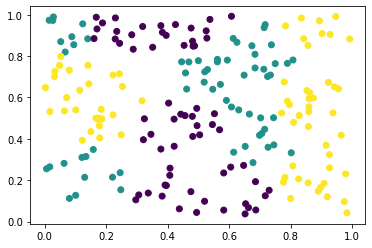

In [2]:
# Read data
df = pd.read_csv('classification2.csv')
x=df.values[:, 0:2]
y=df.values[:,2]
cost=df.values[:,3]
plt.scatter(x[:, 0], x[:, 1],c=y)
plt.show()

In [91]:
# utilities
def getModel():
    #model = SGDClassifier(loss='log')
    #model = LogisticRegression()
    kernel = RBF(length_scale=1)
    model = GaussianProcessClassifier(kernel=kernel, random_state=0)
    # Gaussian process works best for this dataset
    return model

# randomly draw n samples from x, y
def drawSample(x, n):
    arr = [i for i in range(len(x))]
    random.shuffle(arr)
    p1, p2 = arr[:n], arr[n:]
    return x[p1], x[p2]

# assumes $performance and $usage has same length
def averageOverBudget(performance, usage, budget, grid):
    gridSize = int(budget/grid)
    outp = [[] for i in range(grid)]
    xgrid = np.arange(0, budget, gridSize)
    for i, pi in enumerate(performance):
        gi = int(usage[i]//gridSize)
        outp[gi].append(pi)
    return np.array([np.mean(i) for i in outp]), xgrid

In [73]:
# proactive-random
def randomCost(x, y, c, init, budget, grid):
    pos = np.arange(len(x))
    obs, unob = drawSample(pos, init) 
    evaluation, budgetUse= [], []
    budgetC = 0
    budgetUse.append(budgetC)
    while True:
        model = getModel()
        model.fit(x[obs], y[obs])
        evaluation.append(model.score(x[unob], y[unob]))
        newObs, unob = drawSample(unob, 1)
        obs = np.append(obs, newObs[0])
        budgetC += c[newObs[0]]
        if budgetC >= budget: break
        budgetUse.append(budgetC)
    return averageOverBudget(evaluation, budgetUse, budget, grid)

In [56]:
# proactive - greedy

# pos correspond to index of unobserved instances
# c is the cost column
def findMinCost(pos, c):
    minc, mincp = np.inf, -1
    for i in pos:
        if c[i] < minc:
            minc = c[i]
            mincp = i
    return mincp

def greedyCost(x, y, c, init, budget, grid):
    pos = np.arange(len(x))
    obs, unob = drawSample(pos, init) 
    evaluation = []
    budgetUse = []
    budgetC = 0
    budgetUse.append(budgetC)
    while True:
        model = getModel()
        model.fit(x[obs], y[obs])
        evaluation.append(model.score(x[unob], y[unob]))
        minP = findMinCost(unob, c)
        obs = np.append(obs, minP)
        unob = np.delete(unob, np.argwhere(unob==minP))
        budgetC += c[minP]
        if budgetC >= budget: break
        budgetUse.append(budgetC)
    return averageOverBudget(evaluation, budgetUse, budget, grid)

In [97]:
# proactive variable cost oracle
# with uncertainty sampling
def utilityMax(model, x, y, c, unob):
    predProb = model.predict_proba(x[unob])
    uncertainty = [1-np.max(i) for i in predProb] # calculate confidence for new data
    utilityCost = [uncertainty[i] -c[p]/100 for i, p in enumerate(unob)] # normalizing cost
    p = unob[np.argmax(utilityCost)]
    return p

def variableCost(x, y, c, init, budget, grid):
    pos = np.arange(len(x))
    obs, unob = drawSample(pos, init) 
    evaluation = []
    budgetUse = []
    budgetC = 0
    budgetUse.append(budgetC)
    while True:
        model = getModel()
        model.fit(x[obs], y[obs])
        evaluation.append(model.score(x[unob], y[unob]))
        # select new sample
        newObs = utilityMax(model, x, y, c, unob)
        obs = np.append(obs, newObs)
        unob = np.delete(unob, np.argwhere(unob==newObs))
        # calculate budget
        budgetC += c[newObs]
        if budgetC >= budget: break
        budgetUse.append(budgetC)
    return averageOverBudget(evaluation, budgetUse, budget, grid)

In [98]:
# 10 simulations
randomProactive, greedyProactive, variableProactive = [], [], []
for i in range(10):
    random.seed(i)
    print("in simulation", i)
    randomPerf, randomAxis = randomCost(x, y, cost, 5, 500, 20)
    randomProactive.append(randomPerf)
    random.seed(i)
    greedyPerf, greedyAxis = greedyCost(x, y, cost, 5, 500, 20)
    greedyProactive.append(greedyPerf)
    random.seed(i)
    variablePerf, variableAxis = variableCost(x, y, cost, 5, 500, 20)
    variableProactive.append(variablePerf)

# calculate stats
randomMean = [np.mean(i) for i in np.transpose(np.array(randomProactive))]
randomStd = [np.std(i) for i in np.transpose(np.array(randomProactive))]
greedyMean = [np.mean(i) for i in np.transpose(np.array(greedyProactive))]
greedyStd = [np.std(i) for i in np.transpose(np.array(greedyProactive))]
variableMean = [np.mean(i) for i in np.transpose(np.array(variableProactive))]
variableStd = [np.std(i) for i in np.transpose(np.array(variableProactive))]

in simulation 0


D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


in simulation 1


D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


in simulation 2


D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


in simulation 3


D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


in simulation 4


D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


in simulation 5


D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\anaconda\lib\site-packages\sklearn\ga

in simulation 6
in simulation 7


D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\anaconda\lib\site-packages\sklearn\ga

in simulation 8


D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


in simulation 9


D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\anaconda\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


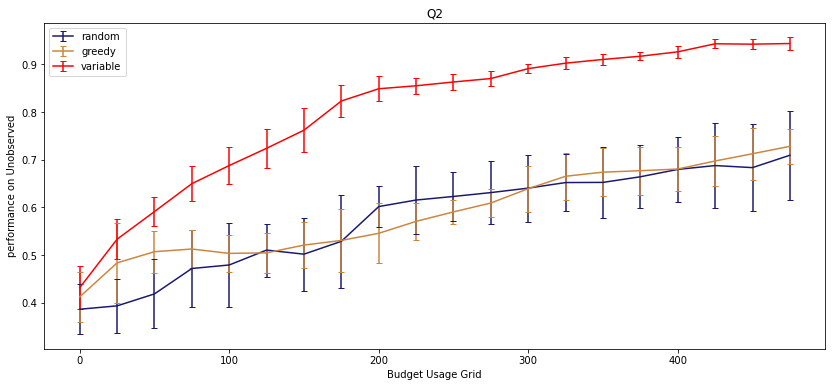

In [99]:
# plot the graph
plt.rcParams["figure.figsize"] = (14,6)
plt.errorbar(randomAxis, randomMean, yerr = randomStd,  label = 'random', color = 'midnightblue', ecolor='midnightblue',capsize=3)
plt.errorbar(greedyAxis, greedyMean, yerr = greedyStd, label = 'greedy', color = 'peru', ecolor='peru',capsize=3)
plt.errorbar(variableAxis, variableMean, yerr = variableStd, label = 'variable', color = 'red', ecolor='red', capsize=3)

plt.xlabel("Budget Usage Grid")
plt.ylabel("performance on Unobserved")
plt.title("Q2")
plt.legend()
plt.show()